In [17]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [18]:
# Read dataset
processed_data = os.path.abspath('../datasets/processed_data.csv')

# merging two csv files
data = pd.read_csv(processed_data)

data.head()

,Location,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,0,2023,2,26,18,48,24.0,47.0,17.0,210.0,13.0,14.0,a_Good
1,7,2023,2,22,20,36,18.0,28.0,8.0,346.0,27.0,7.0,a_Good
2,0,2023,2,28,18,37,19.0,37.0,18.0,272.0,11.0,21.0,a_Good
3,0,2023,2,28,18,37,19.0,37.0,18.0,272.0,11.0,21.0,a_Good
4,0,2023,2,27,18,47,24.0,46.0,19.0,216.0,8.0,14.0,a_Good


In [19]:
# Transforming categorical variables
label_encoder = LabelEncoder()
data['AQI_Class'] = label_encoder.fit_transform(data['AQI_Class'])

In [20]:
# Selecting features and target variable
X = data[['Location', 'Year', 'Month', 'Day', 'Hour', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']]
y = data['AQI_Class']

In [21]:
# Data scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Converting the target variable to one-hot encoding
y = to_categorical(y)

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data transformation for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [22]:
# Building an LSTM model
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

print(model.summary())

/Users/macbook/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 11, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,246 (461.90 KB)

 Trainable params: 118,246 (461.90 KB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
# Model compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
# Model training
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.2575 - loss: 1.6836 - val_accuracy: 0.4833 - val_loss: 1.0868
Epoch 2/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5192 - loss: 1.0665 - val_accuracy: 0.6066 - val_loss: 0.8571
Epoch 3/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6335 - loss: 0.8336 - val_accuracy: 0.7455 - val_loss: 0.6427
Epoch 4/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7246 - loss: 0.6472 - val_accuracy: 0.7541 - val_loss: 0.5845
Epoch 5/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7737 - loss: 0.5643 - val_accuracy: 0.8047 - val_loss: 0.5140
Epoch 6/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7974 - loss: 0.5276 - val_accuracy: 0.8350 - val_loss: 0.4680
Epoch 7/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8031 - loss: 0.5133 - val_accuracy: 0.8342 - val_loss: 0.4673
Epoch 8/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8367 - loss: 0.4623 - val_accu

In [25]:
# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 96.85%


In [26]:
# Prognostication
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [27]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred, target_names=label_encoder.classes_))

Classification Report:
                                  precision    recall  f1-score   support

                          a_Good       0.96      0.97      0.97       314
                      b_Moderate       0.99      0.94      0.96       321
c_Unhealthy_for_Sensitive_Groups       0.96      0.98      0.97       585
                     d_Unhealthy       0.97      0.97      0.97       521
                e_Very_Unhealthy       0.98      0.97      0.97       444
                        f_Severe       0.95      0.96      0.96       263

                        accuracy                           0.97      2448
                       macro avg       0.97      0.97      0.97      2448
                    weighted avg       0.97      0.97      0.97      2448



In [28]:
# F1 Score
f1 = f1_score(y_test_classes, y_pred, average='weighted')
print(f"F1 Score (weighted): {f1:.2f}")

F1 Score (weighted): 0.97


Confusion Matrix


<Axes: >

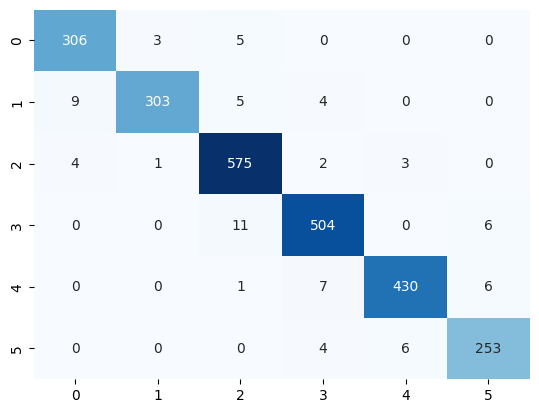

In [29]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred)
print("Confusion Matrix")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

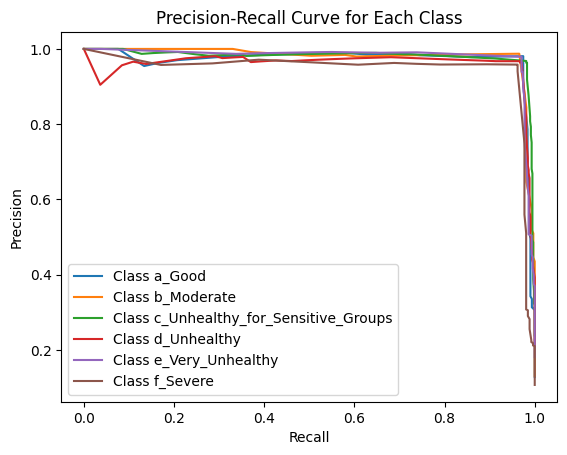

In [30]:
# Precision-Recall Curve for each class
plt.figure()
for i, class_name in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f'Class {class_name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()

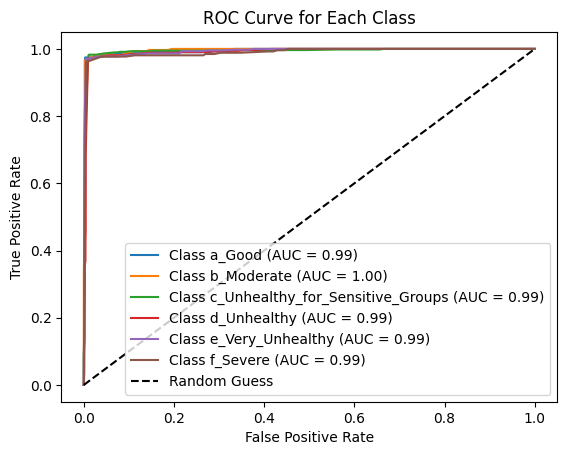

In [31]:
# ROC Curve and AUC for each class
plt.figure()
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend()
plt.show()

In [32]:
# Saving the model
model.save("serialized/keras/lstmModel.keras")

In [33]:
# Creating an object to save
custom_object = {
    "model_path": "serialized/keras/lstmModel.keras",
    "additional_info": "This is an LSTM model for AQI classification"
}

# Saving an object in pickle
with open("serialized/LSTMModel.pkl", "wb") as f:
    pickle.dump(custom_object, f)